## Manifold Scultping

In this folder is provided an implementation in Python of the Manifold Scultping algorithm, as described in the paper "Iterative Non-linear Dimensionality Reduction by Manifold Sculpting" by Michael Gashler, Dan Ventura, and Tony Martinez.

In this notebook, the steps are shown by one by one in order to illustrate the functioning of the algorithm.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pca import *
from manifold_scultpting import *
from utils import *

In [2]:
import ipywidgets as widgets # this is needed to make the 3d plot interactive

### 1st step: find k nearest neighbors of each point
### 2nd point: compute relationships between neighbors


These two steps are merged in a unique one which is implemented by the function `get_local_relationships(data, k)`, which takes as input the data matrix `X` and the number of neighbors `k` and returns the matrices of relationships between neighbors and the average distance between each point and its neighbors.

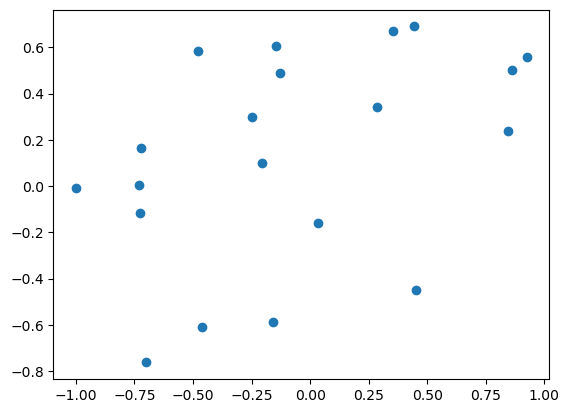

In [2]:
# generate random datapoints
# generate random points in 2d and plot them
data = np.random.uniform(-1, 1, (20, 2))
plt.scatter(data[:,0], data[:,1])
plt.show()

In [3]:
# call function to get the desired relationships
neighbors, dist, colinear, theta, avg_dist = get_local_relationships(data, k=5)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


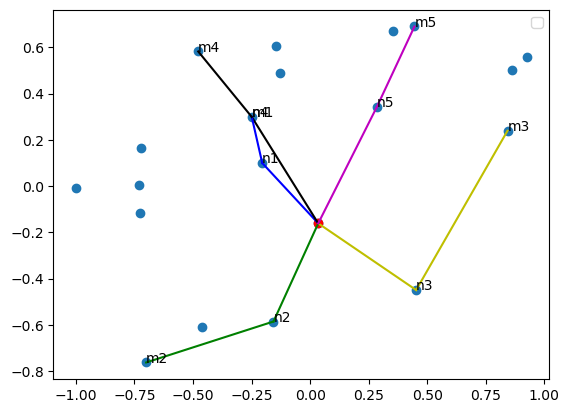

In [23]:
# choose one point and plot relationships
point = 6
plt.scatter(data[:,0], data[:,1])
plt.scatter(data[point,0], data[point,1], c='r')

color = ['b', 'g', 'y', 'k', 'm']
for i in range(5):
    j = int(neighbors[point, i])
    plt.plot([data[point,0], data[j,0]], [data[point,1], data[j,1]], c=color[i])
    plt.annotate('n%d' %(i+1), (data[j,0], data[j,1]))


# plot the most colinear neighbor of each neighbor of the chosen point
for i,idx in enumerate(colinear[point,:]):
    j = int(neighbors[point, i])
    plt.plot([data[j,0], data[int(idx),0]], [data[j,1], data[int(idx), 1]], c=color[i])
    plt.annotate('m%d' %(i+1), (data[int(idx),0], data[int(idx),1]))

plt.legend()
plt.show()


### Step 3: optionally preprocess the data

The following steps are illustrated on the data set `swiss_roll` which is a 3D data set with a non-linear structure. The data set is loaded and plotted below.

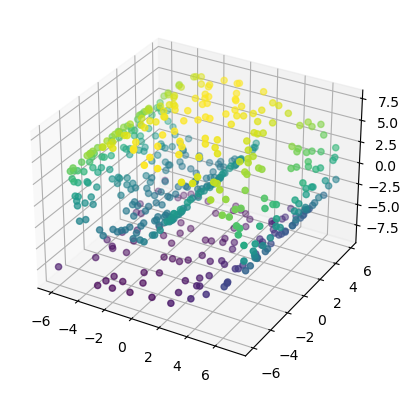

In [20]:
# generate swiss roll dataset
data = generate_swiss_roll(500)

# center the data
X = data - np.mean(data, axis=0)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=X[:,2], cmap='viridis')

plt.show()

PCA is used to find the first $|D_{pres}|$ principal components (n. of dimensions to be preserved) and optionally rotate the dimensional axes to align with these principal components. No projection is performed, then the implementation provided for PCA removes the last step of the algorithm.

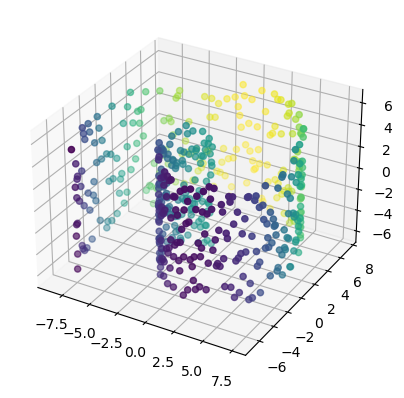

In [21]:
# apply pca to the data
idx, U = pca_alg(X, 3) # keep all dimensions to see just the rotation
y = np.dot(X, U)

# plot the data in the new space
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y[:,0], y[:,1], y[:,2], c=X[:,0], cmap='viridis')

plt.show()

Which dimensions PCA is preserving? 

Those are the ones which are going to be selected by **Manifold algorithm** to be the ones which make $D_{pres}$, while the others are in $D_{scal}$ and information is going to be scaled out of them. 

In [22]:
# dimensions as they are ordered by pca
idx

array([2, 0, 1], dtype=int64)

This is the result of the PCA preprocessing step, if we apply also the projection, we obtain the following result.

Manifold Sculpting uses PCA only to find the dimensions to be preserved and to align axes with principal components in order to make the algorithm faster, but the projection is not performed, it is progressively achieved thorugh an iterative procedure.

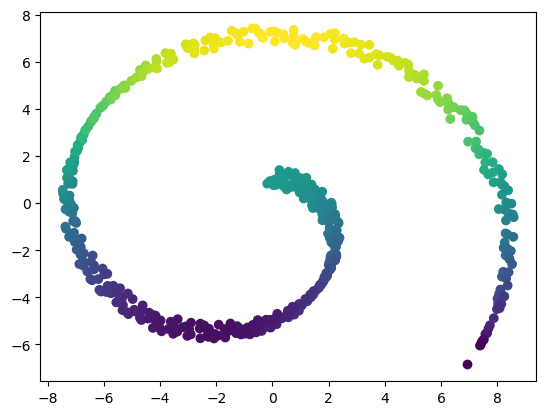

In [25]:
fig = plt.figure()

ax = fig.add_subplot(111)
ax.scatter(y[:,0], y[:,1], c=X[:,0], cmap='viridis')

### Step 4: Transform the data
- Scale the values along the dimensions to be discarded.
- Restore the original relationships found at step 2.


### Step 5: project the data

In [6]:

def get_avg_dist(data, neighbors):

    avg_dist = 0
    k = neighbors.shape[1]
    for i in range(data.shape[0]):
        for j in range(k):
            avg_dist += np.linalg.norm(data[i,:] - data[neighbors[i,j],:])/k

    avg_dist /= data.shape[0]

    return avg_dist


def manifold_sculpting(data, k = 10, ndim=2, max_iter = 1000, th = 10**(-5)):
    """
    input:
        data: the dataset representing the manifold
        k: number of nearest neighbors to consider
        ndim: number of dimensions of the output space
        max_iter: maximum number of iterations
        th: threshold to stop the algorithm
    output:
        data transformed and projected in the 2D space
    """
    sigma = 0.9 # scaling factor

    # first step: find the k nearest neighbors for each point
    # second step: compute the distance between each point and its neighbors
    neighbors, dist0, colinear, angles0, avg_dist0 = get_local_relationships(data, k) # matrix of distances with only the k nearest neighbors

    eta = copy.deepcopy(avg_dist0)
    
    # third step: find principal directions through PCA
    # and align the data along the principal directions (not done for the moment)
    #idx, _ = pca_alg(data, 2)

    #dpres = idx[:ndim]  # dimensions to be preserved
    #dscal = idx[ndim:] # dimensions to be discarded

    #pca = PCA(n_components=3)
    #pca.fit(data)
    #x_pca = pca.transform(data)

    idx, U = pca_alg(data, 3) # keep all dimensions to see just the rotation
    x_pca =  copy.deepcopy(data) #np.dot(data, U) 

    dpres = idx[:ndim]
    dscal = idx[ndim:]
    print("Dimensions which are going to be preserved: ", dpres)
    print("Dimensions which are going to be discarded: ", dscal)
    
    prev_data = copy.deepcopy(x_pca)
    # fourth step: iteratively transform data until stop criterion is met
    # stop when all sum of changes for all the points is less than a threshold
    # or if the maximum number of iterations is reached

    for i in tqdm(range(max_iter)):

        # 4a: scale the data along the discarded dimensions
        for j in range(x_pca.shape[0]):
            x_pca[j, dscal] *= sigma

        # The values in Dpres are scaled up to keep 
        # the average neighbor distance equal to avg_dist
        while get_avg_dist(x_pca, neighbors) < avg_dist0:
            for j in range(x_pca.shape[0]):
                x_pca[j, dpres] /= sigma

        
        # create queue of points 
        q = queue.Queue()

        # add a random point to the queue
        curr_idx =  np.random.randint(0, x_pca.shape[0], 1).item()
        q.put(curr_idx)

        # keep list of adjusted points
        adj_data = []

        step = 0 
        # while queue is not empty
        while not q.empty():
            # pick point from queue
            curr_idx = q.get()
            
            if curr_idx not in adj_data: # if current point has not been adjusted jet
                s, x_pca = adjust_points(x_pca, curr_idx, eta, avg_dist0, dpres, neighbors, dist0, colinear, angles0, adj_data)
                
                step += s
                # add current point to adjusted points
                adj_data.append(curr_idx)

                # add neighbors to queue
                for n in neighbors[curr_idx, :]:
                    q.put(int(n))


       

        # stop criterion
        # if data has not changed much, stop
        change = np.sum(np.abs(x_pca - prev_data))
        prev_data = copy.deepcopy(x_pca)

        if change < th:
            print("Converged after {} iterations".format(i))
            break
        
        if i % 10 == 0:
            print("Iteration: {}, change: {}".format(i, change))

            # if representations of intermediate steps are desired
            # one can uncomment the following lines
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(x_pca[:,0], x_pca[:,1], x_pca[:,2], c=X[:,2], cmap='viridis')
            ax.set_zlim([-8,4])
            
            
            # change the angle of the axes
            ax.view_init(10, -60)
            filename = str(i)+ '_iterations.png'
            plt.savefig(filename)   # save the figure to file
            plt.close(fig) 

    # final step: project points by dropping the discarded dimensions
    return x_pca#[:, dpres]



def compute_error(data, curr_idx, avg_dist, neighbors, dist0, colinear, angles0, adj_data):
    c = 10
    error = 0
    # heuristic error value is used to evaluate the current relationships
    # among data points relative to the original relationships

    for i,j in enumerate(neighbors[curr_idx, :]):
        # weight of the error
        w = 1 
        # change weight if point j has already been adjusted
        if j in adj_data:
            w = c
        
        # distance between current point and point j
        new_dist = np.linalg.norm(data[curr_idx, :] - data[j, :])
        v1 = data[curr_idx, :] - data[j, :] # dist between curr point and point j
        v2 = data[colinear[curr_idx,i], :] - data[j, :] # dist between colinear point with current one through point j and point j

        #new_angle = np.arccos(np.dot(v1,v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))) if (np.linalg.norm(v1) * np.linalg.norm(v2)) != 0 else 0

        try:
            if (np.linalg.norm(v1) * np.linalg.norm(v2)) == 0:
                new_angle = 0
            else:
                new_angle = np.arccos(np.clip(np.dot(v1,v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)), -1,1))
        except:
            print('v1: ', v1)
            print('v2: ', v2)
            print('np.linalg.norm(v1): ', np.linalg.norm(v1))
            print('np.linalg.norm(v2): ', np.linalg.norm(v2))
            print('np.dot(v1,v2): ', np.dot(v1,v2))

        error_dist = (( dist0[curr_idx, i] - new_dist)/(2*avg_dist))**2 
        error_angle  = ((angles0[curr_idx, i] - new_angle)/np.pi)**2
        
        error += w *( error_dist + error_angle )

    return error



def adjust_points(data, curr_idx, eta, avg_dist, dpres, neighbors, dist0, colinear, angles0, adj_data):
    s = 0
    improved = True

    eta = 0.3*eta
    
    while improved: # until we are in a local minimum
        s += 1
        improved = False

        error = compute_error(data, curr_idx, avg_dist, neighbors, dist0, colinear, angles0, adj_data)

        for d in dpres:
            data[curr_idx, d] += eta
            
            new_error = compute_error(data, curr_idx, avg_dist, neighbors, dist0, colinear, angles0, adj_data)
            # empirically moving along one of the direction to be preserved
            # choosing the versus by evaluating how the error changes moving both up and down
            if new_error > error:
                data[curr_idx, d] -= 2*eta
                
                new_error = compute_error(data, curr_idx, avg_dist, neighbors, dist0, colinear, angles0, adj_data)
                if  new_error > error:
                    data[curr_idx, d] += eta
                else:
                    improved = True
            else:
                improved = True

    return s, data


First thing: decide hyperparameter $k$, which is the number of neighbors to be considered.
This is very important, a suitable value can be found by visualizing which points are connected and avoid to have to many points connected across different parts of the manifold.

In [47]:
ds = copy.deepcopy(X)
nn=10

# call function to get the desired relationships
neighbors, dist, colinear, theta, avg_dist = get_local_relationships(ds, k=nn)

neighbors.shape

(500, 10)

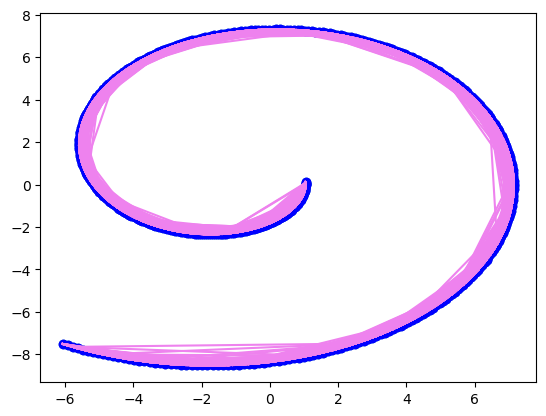

In [49]:
%matplotlib inline
# choose one point and plot relationships
plt.scatter(ds[:,0], ds[:,2])
for point in range(data.shape[0]):
    plt.scatter(ds[point,0], ds[point,2], c='b')

for point in range(data.shape[0]):
    for i in range(nn):
        j = int(neighbors[point, i])
        plt.plot([ds[point,0], ds[j,0]], [ds[point,2], ds[j,2]], c='violet')


# plot the most colinear neighbor of each neighbor of the chosen point
for point in range(data.shape[0]):
    for i,idx in enumerate(colinear[point,:]):
        plt.plot([ds[point,0], ds[int(idx),0]], [ds[point,2], ds[int(idx), 2]], c='violet')


plt.show()

It seems this number of neighbors could work well for this data set.
So now we can start the iterative procedure.

In [50]:
ds = copy.deepcopy(X)
results = manifold_sculpting(ds, k = 12, max_iter = 80, th = 10**(-5))

Dimensions which are going to be preserved:  [0 1]
Dimensions which are going to be discarded:  [2]


  1%|▏         | 1/80 [00:02<03:42,  2.82s/it]

Iteration: 0, change: 579.7613324279056


 14%|█▍        | 11/80 [00:57<06:50,  5.95s/it]

Iteration: 10, change: 855.219065539032


 26%|██▋       | 21/80 [01:50<05:08,  5.23s/it]

Iteration: 20, change: 790.9364087526624


 39%|███▉      | 31/80 [02:42<03:45,  4.61s/it]

Iteration: 30, change: 349.3409901405896


 51%|█████▏    | 41/80 [03:25<02:18,  3.56s/it]

Iteration: 40, change: 160.15352091262451


 64%|██████▍   | 51/80 [03:58<01:26,  2.97s/it]

Iteration: 50, change: 121.23509407664653


 76%|███████▋  | 61/80 [04:27<00:58,  3.10s/it]

Iteration: 60, change: 159.88772715372076


 89%|████████▉ | 71/80 [04:58<00:26,  2.91s/it]

Iteration: 70, change: 150.97246693794932


100%|██████████| 80/80 [05:25<00:00,  4.07s/it]


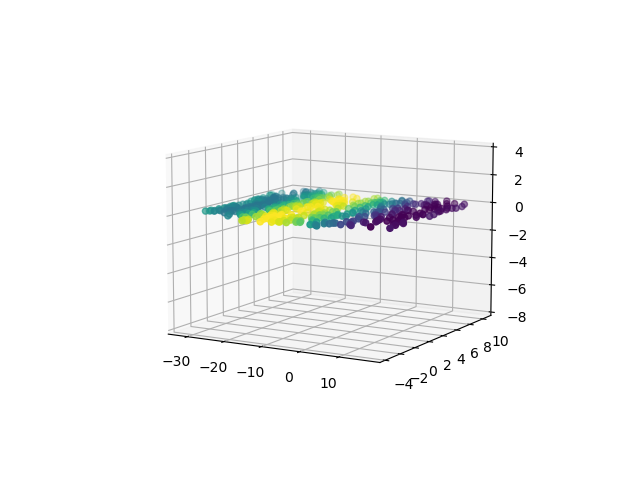

In [51]:
%matplotlib widget  

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(results[:,0], results[:,1], results[:,2], c=X[:,2], cmap='viridis')


# change the angle of the axes
ax.view_init(10, -60)
ax.set_zlim([-8,4])

plt.show()

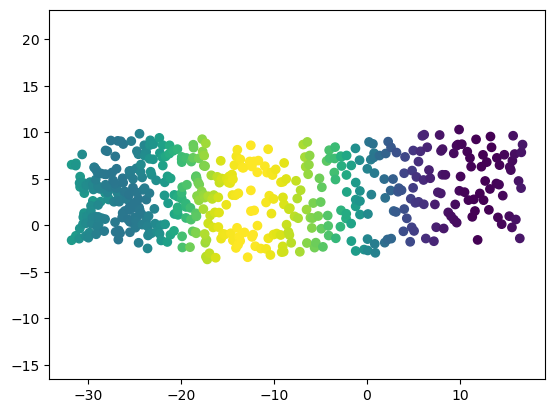

In [54]:
%matplotlib inline

plt.scatter(results[:,0], results[:,1], c=X[:,2], cmap='viridis')
# make axis equal
plt.axis('equal')
plt.show()

In [7]:
ds = copy.deepcopy(X)
results = manifold_sculpting(ds, k = 12, max_iter = 110, th = 10**(-5))

Dimensions which are going to be preserved:  [0 1]
Dimensions which are going to be discarded:  [2]


  1%|          | 1/110 [00:02<05:09,  2.84s/it]

Iteration: 0, change: 600.0870480055223


 10%|█         | 11/110 [00:58<09:12,  5.58s/it]

Iteration: 10, change: 533.4436978244775


 19%|█▉        | 21/110 [01:42<06:04,  4.10s/it]

Iteration: 20, change: 409.1284399986166


 28%|██▊       | 31/110 [02:24<05:47,  4.40s/it]

Iteration: 30, change: 411.3273330544333


 37%|███▋      | 41/110 [03:02<04:21,  3.79s/it]

Iteration: 40, change: 240.60460006173423


 46%|████▋     | 51/110 [03:43<04:12,  4.28s/it]

Iteration: 50, change: 468.67172863897196


 55%|█████▌    | 61/110 [04:36<04:34,  5.60s/it]

Iteration: 60, change: 743.0520594765446


 65%|██████▍   | 71/110 [05:43<04:33,  7.02s/it]

Iteration: 70, change: 1023.3263846056249


 73%|███████▎  | 80/110 [06:44<03:25,  6.85s/it]

Iteration: 80, change: 879.3511169031351


 83%|████████▎ | 91/110 [08:03<02:10,  6.86s/it]

Iteration: 90, change: 693.5345791271379


 92%|█████████▏| 101/110 [09:04<00:51,  5.75s/it]

Iteration: 100, change: 564.201408999871


100%|██████████| 110/110 [09:44<00:00,  5.31s/it]


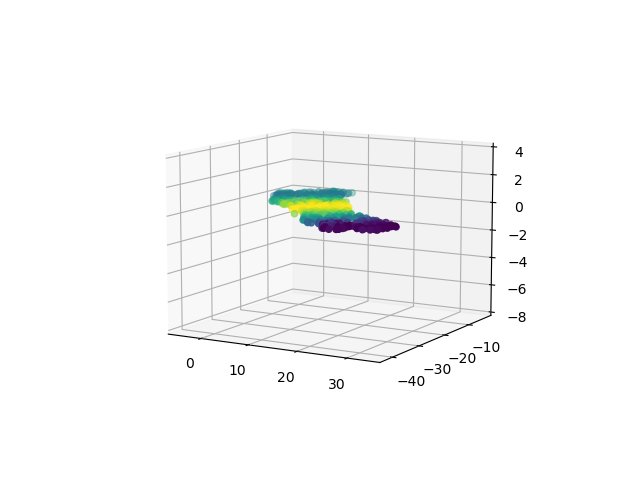

In [8]:
%matplotlib widget  

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(results[:,0], results[:,1], results[:,2], c=X[:,2], cmap='viridis')


# change the angle of the axes
ax.view_init(10, -60)
ax.set_zlim([-8,4])

plt.show()

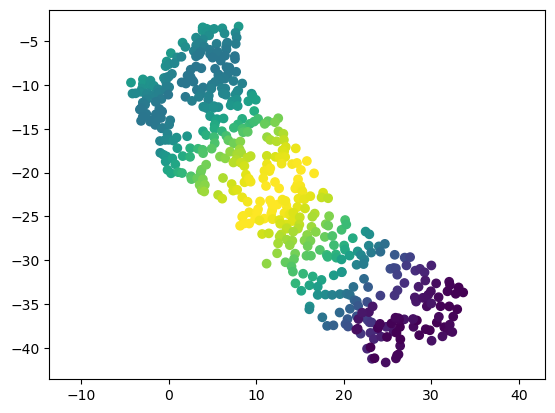

In [9]:
%matplotlib inline

plt.scatter(results[:,0], results[:,1], c=X[:,2], cmap='viridis')
# make axis equal
plt.axis('equal')
plt.show()